In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-17 14:42:15 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-17 14:42:15 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-17 14:42:15 __main__ INFO     transformers.__version__='4.54.1'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-17 14:42:19 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-17 14:42:19 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-17 14:42:19 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-17 14:42:19 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-17 14:42:21 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-17 14:42:21 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-08-17 14:42:21 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-08-17 14:42:21 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-08-17 14:42:21 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-08-17 14:43:08 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-08-17 14:43:08 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-17 14:43:08 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [6]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [7]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Pineapple -> Strawberry (2): ['Pen', 'Eagle', 'Strawberry', 'Brooch', 'Gloves', 'Accordion']
Options: Pen, Eagle, Strawberry, Brooch, Gloves, Accordion.
Which among these objects mentioned above is a fruit?
Answer:


In [8]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Pen, Eagle, Strawberry, Brooch, Gloves, Accordion.
Which among these objects mentioned above is a fruit?
Answer:" >> Strawberry


(True,
 [PredictedToken(token=' Strawberry', prob=0.72265625, logit=21.375, token_id=89077, metadata=None),
  PredictedToken(token=' The', prob=0.1259765625, logit=19.625, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.076171875, logit=19.125, token_id=22395, metadata=None),
  PredictedToken(token=' A', prob=0.0247802734375, logit=18.0, token_id=362, metadata=None),
  PredictedToken(token=' strawberry', prob=0.008056640625, logit=16.875, token_id=73700, metadata=None)],
 OrderedDict([(89077,
               (1,
                PredictedToken(token=' Strawberry', prob=0.72265625, logit=21.375, token_id=89077, metadata=None))),
              (11683,
               (39,
                PredictedToken(token=' Acc', prob=0.00021457672119140625, logit=13.25, token_id=11683, metadata=None))),
              (36895,
               (58,
                PredictedToken(token=' Eagle', prob=7.867813110351562e-05, logit=12.25, token_id=36895, metadata=None))),
              (60

In [9]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


" Strawberry.
Explanation: Strawberry is a fruit. The other options are not fruits. Pen is a writing" >> Strawberry


In [10]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [11]:
HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]
# HEADS = [(35, 19)]


# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]


print(len(HEADS))

10


2025-08-17 14:55:01 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-08-17 14:55:01 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-08-17 14:55:01 matplotlib DEBUG    interactive is False
2025-08-17 14:55:01 matplotlib DEBUG    platform is linux
2025-08-17 14:55:01 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-08-17 14:55:01 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-08-17 14:55:02 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-17 14:55:02 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-17 14:55:02 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-17 14:55:02 matplotlib.font

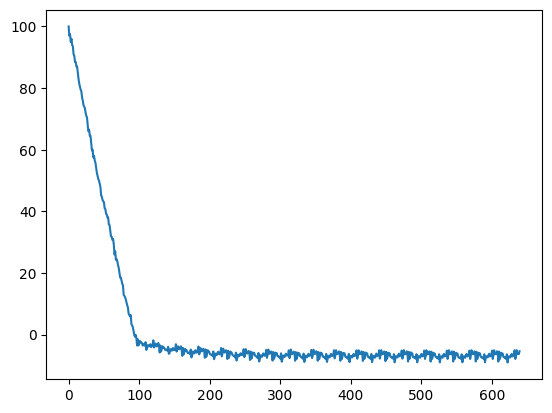

In [12]:
from matplotlib import pyplot as plt
import numpy as np

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    f"{select_task.task_name}.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

66


(True, True)

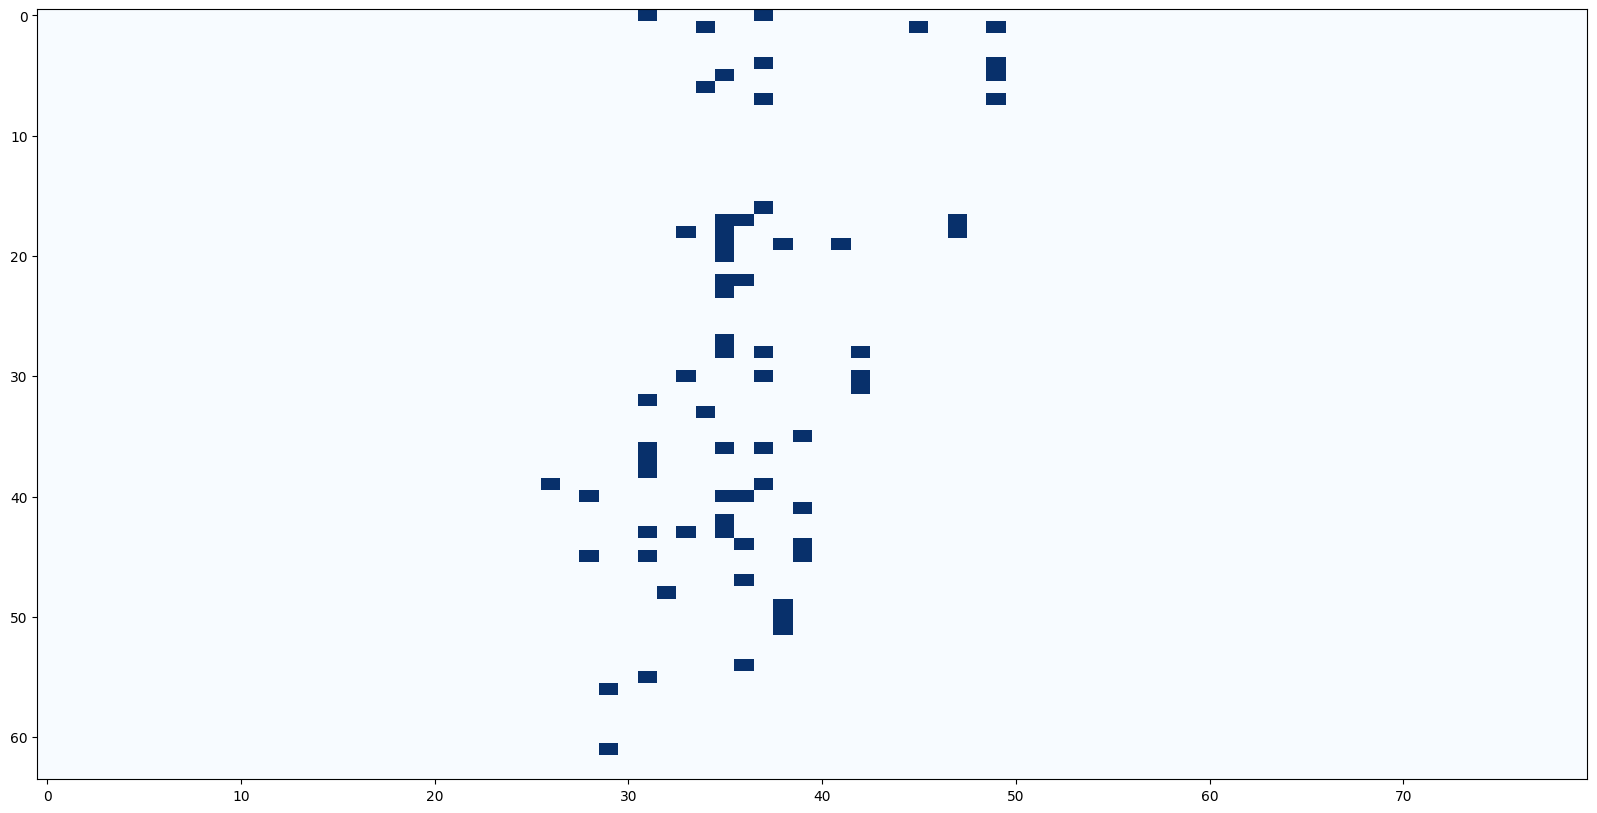

In [13]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
print(len(heads_selected))

HEADS = heads_selected

(35, 19) in HEADS, (35, 19) in heads_selected

In [14]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=HEADS,
)

0 patches to ablate possible answer information from options
2025-08-17 14:55:12 src.selection.functional DEBUG    Predictions: ['" Strawberry"[89077] (p=0.723, logit=21.375)', '" The"[578] (p=0.126, logit=19.625)', '" Among"[22395] (p=0.076, logit=19.125)', '" A"[362] (p=0.025, logit=18.000)', '" strawberry"[73700] (p=0.008, logit=16.875)']
2025-08-17 14:55:12 src.selection.functional INFO     Combined attention matrix for all heads


In [49]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
WINDOW_SPEC = {
    mt.layer_name_format: 1,
    mt.mlp_module_name_format: 9,
    mt.attn_module_name_format: 9,
}
module_name_format = mt.layer_name_format
# module_name_format = mt.mlp_module_name_format
# module_name_format = mt.attn_module_name_format

######################################################################


@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task: SelectOneTask | SelectOrderTask = select_task,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    prompt_template_idx=2,
    clean_option_style="numbered",
    patch_option_style="single_line",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
    n_distractors: int = N_DISTRACTORS,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (
            KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)
        ).values,
        2,
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer)
                - KeyedSet([patch_obj], mt.tokenizer)
            ).values
        )
        clean_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer)
                - KeyedSet([clean_obj], mt.tokenizer)
            ).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_type_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=N_DISTRACTORS - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors,
                            tokenizer=mt.tokenizer,
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while clean_options.index(clean_obj) == patch_obj_idx:
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    print(f"{type(task)=}")
    if isinstance(task, SelectOrderTask):
        patch_metadata = {
            "track_type_obj_idx": clean_obj_idx,
            "track_type_obj": patch_options[clean_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                patch_options[clean_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_type_obj_idx": patch_obj_idx,
            "track_type_obj": clean_options[patch_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                clean_options[patch_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
    elif isinstance(task, SelectOneTask):
        patch_metadata = {
            "track_category": clean_category,
            "track_type_obj": clean_type_obj,
            "track_type_obj_idx": patch_options.index(clean_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                clean_type_obj, mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_category": patch_category,
            "track_type_obj": patch_type_obj,
            "track_type_obj_idx": clean_options.index(patch_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                patch_type_obj, mt.tokenizer, prefix=" "
            ),
        }
    else:
        raise NotImplementedError(f"Unsupported task type: {type(task)}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata=patch_metadata,
        prompt_template = task.prompt_templates[prompt_template_idx],
        default_option_style=patch_option_style,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata=clean_metadata,
        prompt_template = task.prompt_templates[prompt_template_idx],
        default_option_style=clean_option_style,
    )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata[
                "track_type_obj_token_id"
            ]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    prompt_template_idx=prompt_template_idx,
                    clean_option_style=clean_option_style,
                    patch_option_style=patch_option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    distinct_options=distinct_options,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

In [50]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    distinct_options=True,
    n_distractors = N_DISTRACTORS,
)

clean_sample.metadata

2025-08-17 15:08:42 __main__ INFO     Patch category: fruit, subject: Mango, object: Grape
2025-08-17 15:08:42 __main__ INFO     Clean category: vehicle, subject: Train, object: Motorcycle


2025-08-17 15:08:42 __main__ INFO     patch_must_have_options=['Grape', 'Boat']
2025-08-17 15:08:42 __main__ INFO     clean_must_have_options=['Motorcycle', 'Mango']
2025-08-17 15:08:42 __main__ INFO     clean_type_obj='Boat'
2025-08-17 15:08:42 __main__ INFO     patch_type_obj='Mango'
2025-08-17 15:08:42 __main__ INFO     patch_obj_idx=4 | ['Dress', 'Baseball', 'Boat', 'Broccoli', 'Grape', 'Ukulele']
2025-08-17 15:08:42 __main__ INFO     clean_obj_idx=5 | ['Toothpaste', 'Router', 'Mango', 'Coat', 'Bamboo', 'Motorcycle']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-17 15:08:42 __main__ INFO     Options: Dress, Baseball, Boat, Broccoli, Grape, Ukulele.
Which among these objects mentioned above is a fruit?
Answer:
2025-08-17 15:08:42 __main__ INFO     Mango | fruit -> Grape | pred=['" Grape"[80629] (p=0.754, logit=21.125)', '" The"[578] (p=0.080, logit=18.875)', '" Among"[22395] (p=0.055, logit=18.500)', '" A"[362] (p=0.048, logit=18.375)', '" There"[2684] (p=0.005, logi

{'track_category': 'fruit',
 'track_type_obj': 'Mango',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 91963,
 'tokenized': {'input_ids': tensor([[128000,     64,     13,  83499,  57968,    198,     65,     13,  10777,
              198,     66,     13,  91963,    198,     67,     13,  68867,    198,
               68,     13,  98028,    198,     69,     13,  70762,    198,  23956,
             4315,   1521,   6302,   9932,   3485,    374,    264,   7458,   5380,
            16533,     25]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}}

In [51]:
# order_sample_1 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Bike", "Apple", "Bed", "Dog", "Monitor", "Theater"],
#     obj="Apple",
#     obj_idx=1,
#     prompt_template="<_options_>\nWhat is the third item in the list?\nAnswer:",
#     answer="Apple",
# )

# order_sample_2 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Cat", "Chair", "Bus", "Phone", "Library", "Orange"],
#     obj="Phone",
#     obj_idx=3,
#     prompt_template="<_options_>\nWhat is the fifth item in the list?\nAnswer:",
#     answer="Phone",
# )
len(HEADS)

66

In [52]:
from src.functional import generate_with_patch

# patch_sample.options[patch_sample.obj_idx] = "Screw"
# patch_sample.options[patch_sample.obj_idx] = patch_sample.obj
# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

for sample in [patch_sample, clean_sample]:
# for sample in [order_sample_1, order_sample_2]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        generate_full_answer=True,
        query_index=-1
    )

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Options: Dress, Baseball, Boat, Broccoli, Grape, Ukulele.
Which among these objects mentioned above is a fruit?
Answer: >> Grape
0 patches to ablate possible answer information from options
2025-08-17 15:08:52 src.selection.functional DEBUG    Generated full answer: " Grape.
Explanation: A fruit is the sweet and fleshy part of a plant that grows from a flower and contains seeds. Among the options,"
2025-08-17 15:08:52 src.selection.functional DEBUG    Predictions: ['" Grape"[80629] (p=0.754, logit=21.125)', '" The"[578] (p=0.080, logit=18.875)', '" Among"[22395] (p=0.055, logit=18.500)', '" A"[362] (p=0.048, logit=18.375)', '" GRA"[65120] (p=0.005, logit=16.125)']
2025-08-17 15:08:52 src.selection.functional INFO     Combined attention matrix for all heads


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


a. Toothpaste
b. Router
c. Mango
d. Coat
e. Bamboo
f. Motorcycle
Which among these objects mentioned above is a vehicle?
Answer: >> Motorcycle
0 patches to ablate possible answer information from options
2025-08-17 15:08:56 src.selection.functional DEBUG    Generated full answer: " f. Motorcycle
Explanation: A motorcycle is a vehicle, which is a means of transportation. It is a two-wheeled motor vehicle. The"
2025-08-17 15:08:56 src.selection.functional DEBUG    Predictions: ['" f"[282] (p=0.531, logit=21.750)', '" ("[320] (p=0.283, logit=21.125)', '" Motorcycle"[70762] (p=0.082, logit=19.875)', '" A"[362] (p=0.038, logit=19.125)', '" The"[578] (p=0.026, logit=18.750)']
2025-08-17 15:08:56 src.selection.functional INFO     Combined attention matrix for all heads


## Validation of the patching effect

In [54]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 256

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        distinct_options=True,
        n_distractors=N_DISTRACTORS,
    )
    validation_set.append((clean, patch))

2025-08-17 15:09:58 __main__ INFO     Patch category: vehicle, subject: Train, object: Ambulance
2025-08-17 15:09:58 __main__ INFO     Clean category: tree, subject: Hickory, object: Spruce
2025-08-17 15:09:58 __main__ INFO     patch_must_have_options=['Ambulance', 'Birch']
2025-08-17 15:09:58 __main__ INFO     clean_must_have_options=['Spruce', 'Car']
2025-08-17 15:09:58 __main__ INFO     clean_type_obj='Birch'
2025-08-17 15:09:58 __main__ INFO     patch_type_obj='Car'
2025-08-17 15:09:58 __main__ INFO     patch_obj_idx=2 | ['Coffee maker', 'Factory', 'Ambulance', 'Tie', 'Birch', 'Tape']
2025-08-17 15:09:58 __main__ INFO     clean_obj_idx=0 | ['Spruce', 'Speaker', 'Jasmine', 'Monkey', 'Boxing gloves', 'Car']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-17 15:09:58 __main__ INFO     Options: Coffee maker, Factory, Ambulance, Tie, Birch, Tape.
Which among these objects mentioned above is a vehicle?
Answer:
2025-08-17 15:09:58 __main__ INFO     Train | vehicle -> Ambulan

In [66]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair


clean, patch = copy.deepcopy(validation_set[28])
# clean.default_option_style="numbered"
# patch.default_option_style="numbered"
# clean, patch = train_set[18]
# clean, patch = clean_sample, patch_sample
# clean, patch = order_sample_2, order_sample_1
# patch, clean = order_sample_1, order_sample_2
# failed_case = failed_cases[0]
# clean = failed_case["clean_sample"]
# patch = failed_case["patch_sample"]

patch.options[patch.obj_idx] = "Mango"
# patch.options = ["#"]
print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    # heads=HEADS,
    heads = heads_selected,
    # heads=[(35, 19)],
    query_indices=[-3, -2, -1],
    verify_head_behavior_on=-1,
    # ablate_possible_ans_info_from_options=True,
    # amplification_scale=1.5,
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": validation_result["clean_track"][clean_obj][0],
    "clean_logit": validation_result["clean_track"][clean_obj][1].logit,
    "target_rank": validation_result["clean_track"][target_obj][0],
    "target_logit": validation_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": validation_result["int_track"][clean_obj][0],
    "clean_logit": validation_result["int_track"][clean_obj][1].logit,
    "target_rank": validation_result["int_track"][target_obj][0],
    "target_logit": validation_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = after_intervention["target_rank"] - before_intervention["target_rank"]
logger.info(f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} ")
logger.info(f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} ")

clean_logit_delta = after_intervention["clean_logit"] - before_intervention["clean_logit"]
target_logit_delta =  after_intervention["target_logit"] - before_intervention["target_logit"]
logger.info(f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} ")
logger.info(f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} ")

a. Warehouse
b. Desk
c. Daisy
d. Cello
e. Pin
f. Van
Which among these objects mentioned above is a flower?
Answer: >> Daisy
Options: Bat, Lavender, Keyboard, Ruler, Mango, Mushroom.
Which among these objects mentioned above is a vehicle?
Answer: >> Yacht
2025-08-17 15:22:58 src.selection.optimization INFO     Verifying head behavior...
2025-08-17 15:22:58 src.selection.optimization INFO     Clean Sample >> Ans: Daisy


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-17 15:23:01 src.selection.functional DEBUG    Generated full answer: " c. Daisy
Explanation: A daisy is a type of flower. It is a small, white or yellowish flower with a yellow center,"
2025-08-17 15:23:02 src.selection.functional DEBUG    Predictions: ['" c"[272] (p=0.715, logit=21.500)', '" ("[320] (p=0.181, logit=20.125)', '" The"[578] (p=0.036, logit=18.500)', '" Option"[7104] (p=0.015, logit=17.625)', '" Daisy"[71264] (p=0.012, logit=17.375)']
2025-08-17 15:23:02 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-17 15:23:02 src.selection.optimization INFO     Patch Sample >> Ans: Yacht


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-17 15:23:05 src.selection.functional DEBUG    Generated full answer: " None of the above. All the objects mentioned are not vehicles. A vehicle is a means of transportation, such as a car, bike, train,"
2025-08-17 15:23:05 src.selection.functional DEBUG    Predictions: ['" None"[2290] (p=0.793, logit=20.000)', '" Bat"[16488] (p=0.121, logit=18.125)', '" There"[2684] (p=0.031, logit=16.750)', '" A"[362] (p=0.010, logit=15.625)', '" The"[578] (p=0.007, logit=15.312)']
2025-08-17 15:23:05 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-17 15:23:05 src.selection.optimization INFO     Caching the query states for the 66 heads
2025-08-17 15:23:06 src.selection.optimization INFO     patch_prediction=['" None"[2290] (p=0.793, logit=20.000)', '" Bat"[16488] (p=0.121, logit=18.125)', '" There"[2684] (p=0.031, logit=16.750)', '" A"[362] (p=0.010, logit=15.625)', '" The"[578] (p=0.007, logit=15.312)']
2025-08-17 15:23:06 src.selection.optimization INFO     clean run
2025-08-17 15:23:06 src.selection.optimization INFO     clean_prediction=['" c"[272] (p=0.715, logit=21.500)', '" ("[320] (p=0.181, logit=20.125)', '" The"[578] (p=0.036, logit=18.500)', '" Option"[7104] (p=0.015, logit=17.625)', '" Daisy"[71264] (p=0.012, logit=17.375)']
2025-08-17 15:23:06 src.selection.optimization INFO     clean_track=OrderedDict([(71264, (5, PredictedToken(token=' Daisy', prob=0.01153564453125, logit=17.375, token_id=71264, metadata=None))), (356, (6, PredictedToken(token=' C', prob=0.01019287109375, logit=17.25, token_id=356, metadat

2025-08-17 15:23:06 src.selection.optimization INFO     int_prediction=['" f"[282] (p=0.291, logit=19.750)', '" Van"[13000] (p=0.258, logit=19.625)', '" ("[320] (p=0.156, logit=19.125)', '" a"[264] (p=0.107, logit=18.750)', '" The"[578] (p=0.045, logit=17.875)']
2025-08-17 15:23:06 src.selection.optimization INFO     int_track=OrderedDict([(13000, (2, PredictedToken(token=' Van', prob=0.2578125, logit=19.625, token_id=13000, metadata=None))), (52466, (13, PredictedToken(token=' Warehouse', prob=0.00390625, logit=15.4375, token_id=52466, metadata=None))), (356, (45, PredictedToken(token=' C', prob=0.0002651214599609375, logit=12.75, token_id=356, metadata=None))), (17929, (55, PredictedToken(token=' Pin', prob=0.00018310546875, logit=12.375, token_id=17929, metadata=None))), (39794, (549, PredictedToken(token=' Desk', prob=2.60770320892334e-06, logit=8.125, token_id=39794, metadata=None))), (71264, (5552, PredictedToken(token=' Daisy', prob=1.1455267667770386e-07, logit=5.0, token_id=71

65


(True, True)

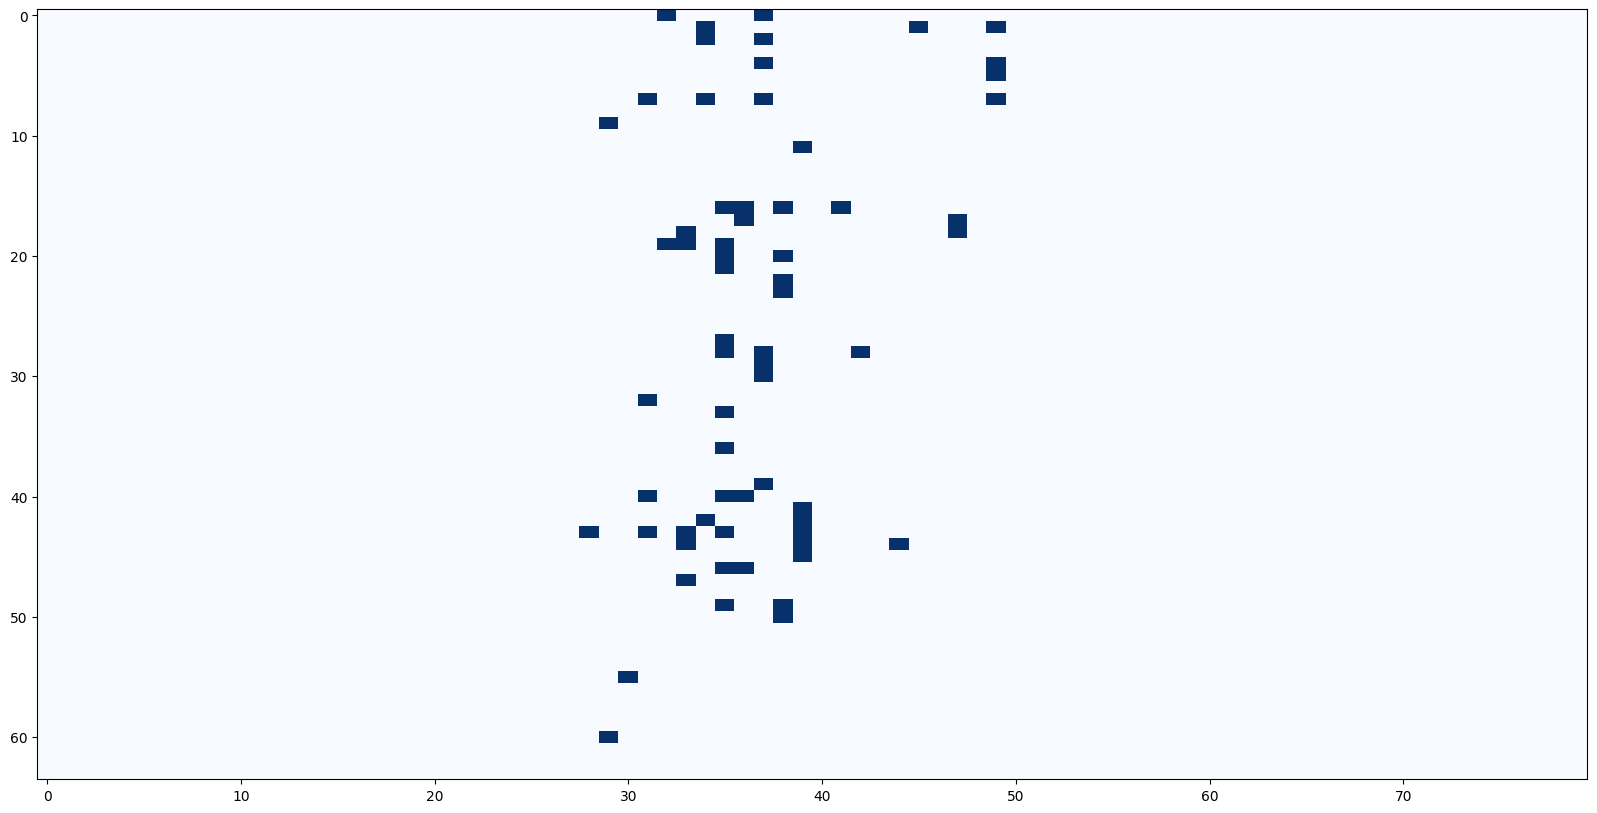

: 

In [ ]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).to(dtype=torch.int).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
print(len(heads_selected))

HEADS = heads_selected

(35, 19) in HEADS, (35, 19) in heads_selected

65


(True, True)

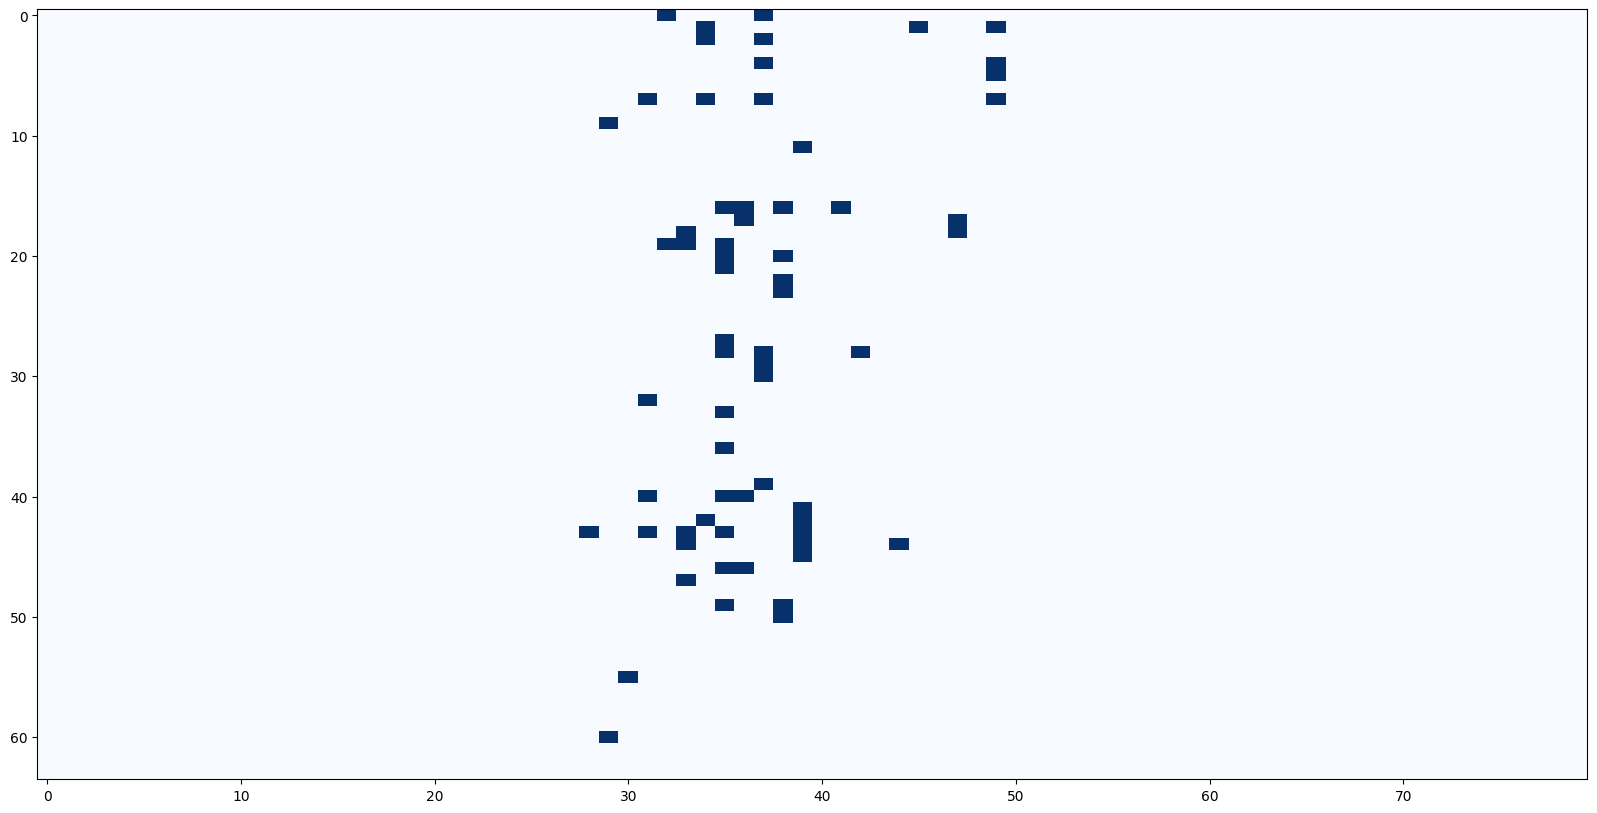

: 

In [ ]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).to(dtype=torch.int).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
print(len(heads_selected))

HEADS = heads_selected

(35, 19) in HEADS, (35, 19) in heads_selected

65


(True, True)

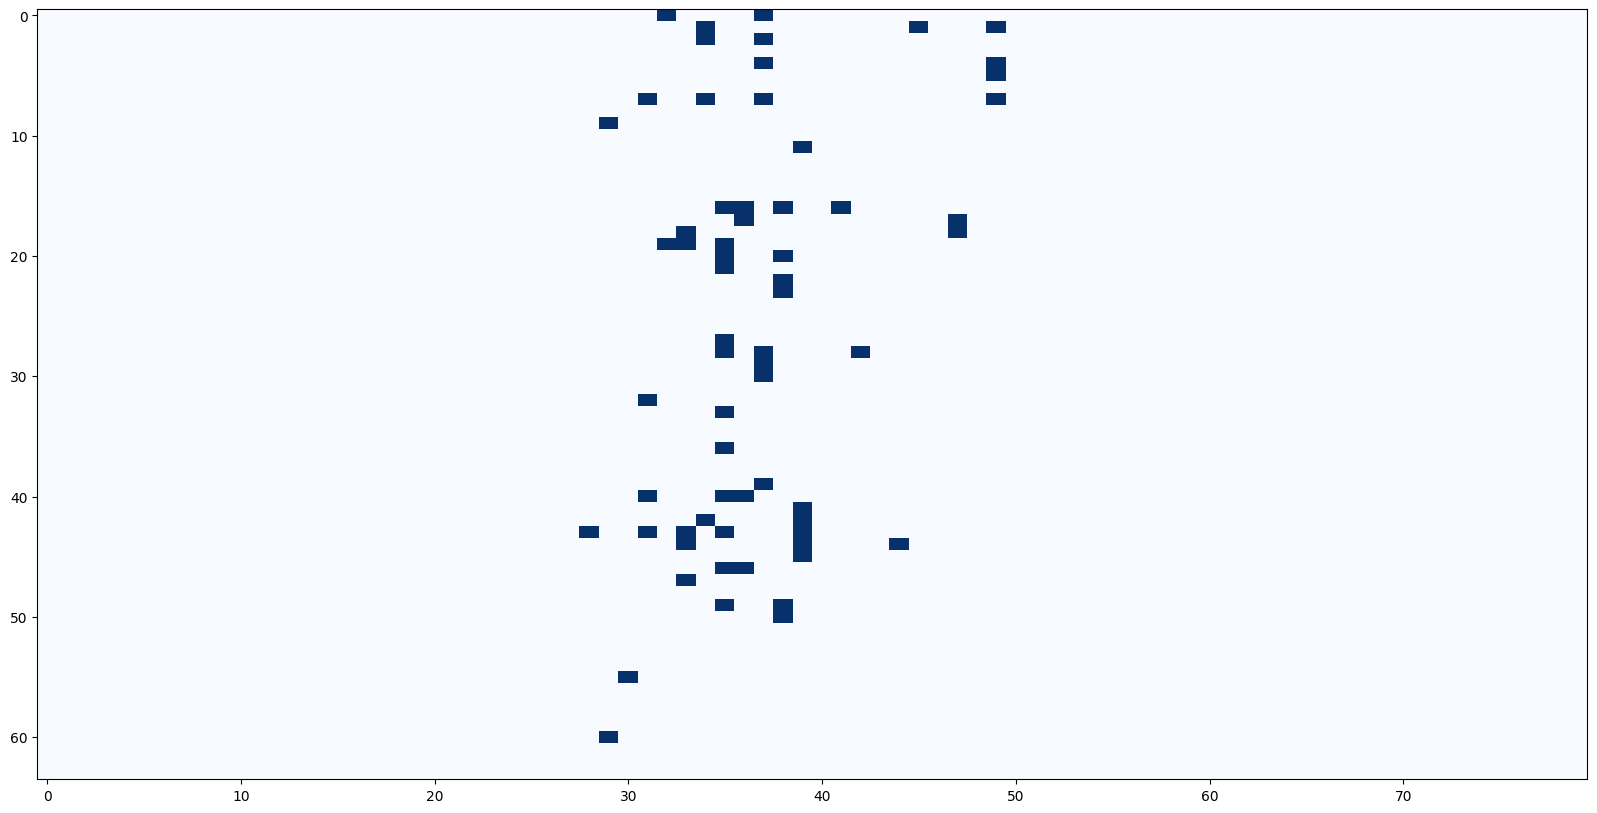

: 

In [ ]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).to(dtype=torch.int).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
print(len(heads_selected))

HEADS = heads_selected

(35, 19) in HEADS, (35, 19) in heads_selected

In [56]:
clean.metadata["track_type_obj"]

'Van'

In [57]:
from tqdm.auto import tqdm

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        # heads=HEADS,
        heads = heads_selected,
        query_indices=[-3, -2, -1],
        verify_head_behavior_on=None,
    )
    validation_results.append(result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-08-17 15:12:25 src.selection.optimization INFO     Caching the query states for the 66 heads


2025-08-17 15:12:25 src.selection.optimization INFO     patch_prediction=['" Amb"[20423] (p=0.559, logit=21.750)', '" An"[1556] (p=0.205, logit=20.750)', '" Among"[22395] (p=0.125, logit=20.250)', '" The"[578] (p=0.076, logit=19.750)', '" It"[1102] (p=0.005, logit=17.000)']
2025-08-17 15:12:25 src.selection.optimization INFO     clean run
2025-08-17 15:12:25 src.selection.optimization INFO     clean_prediction=['" a"[264] (p=0.707, logit=21.750)', '" Spr"[15883] (p=0.108, logit=19.875)', '" ("[320] (p=0.084, logit=19.625)', '" Option"[7104] (p=0.040, logit=18.875)', '" The"[578] (p=0.017, logit=18.000)']
2025-08-17 15:12:25 src.selection.optimization INFO     clean_track=OrderedDict([(15883, (2, PredictedToken(token=' Spr', prob=0.1083984375, logit=19.875, token_id=15883, metadata=None))), (82452, (13, PredictedToken(token=' Jasmine', prob=0.00145721435546875, logit=15.5625, token_id=82452, metadata=None))), (3341, (249, PredictedToken(token=' Car', prob=2.637505531311035e-06, logit=9.

In [58]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [59]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 1444.0117 ± 2242.5652
target_rank_delta: -926.4492 ± 2360.7541
clean_rank_after_intervention: 1448.3203 ± 2242.7833
target_rank_after_intervention: 84.8984 ± 463.9518


In [60]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -10.0352 ± 2.9217
target_logit_delta: 7.1710 ± 3.9670
clean_logit_after_intervention: 8.5959 ± 2.7543
target_logit_after_intervention: 16.9709 ± 3.2064


In [61]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.0078125

In [62]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)

Counterfactual patching accuracy: 0.7070 (181/256)


In [71]:
for failed_case in failed_cases[:20]:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", clean_sample.obj)

    print("-" * 100)
    print(
        "Track: ",
        clean_sample.metadata["track_type_obj"], " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", clean_sample.obj, f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

Clean Sample:
Options: Tiara, Lettuce, Pineapple, Skyscraper, Helmet, Ruler.
What is the second object from the list above?
Answer: >> Lettuce
----------------------------------------------------------------------------------------------------
Track:  Helmet  | Token" Helmet"
Clean: Lettuce (Token:  Let)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Let\"[6771] (p=0.223, logit=32.500)",
    "\" Helmet\"[66529] (p=0.000, logit=21.625)",
    "\" R\"[431] (p=0.000, logit=20.750)",
    "\" Pine\"[41509] (p=0.000, logit=20.375)",
    "\" Sk\"[4818] (p=0.000, logit=17.375)",
    "\" Ti\"[22325] (p=0.000, logit=13.312)"
]
Intervened Track: [
    "\" R\"[431] (p=0.147, logit=34.000)",
    "\" Helmet\"[66529] (p=0.000, logit=27.500)",
    "\" Sk\"[4818] (p=0.000, logit=26.000)",
    "\" Pine\"[41509] (p=0.000, logit=24.750)",
    "\" Let\"[6771] (p=0.000, logit=24.375)",
    "\" Ti\"[22325] (p=0.000, logit=10.812)"
]
